## Convert .bin drawing to .npy drawing

### Import

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from random import randint
import re

### Load data

In [2]:
object_file = open("object.txt", "r")
objects = object_file.readlines()
object_file.close()
N_CLASSES = len(objects)
CLASSES = {}
for idx, obj in enumerate(objects):
    CLASSES[idx] = obj.replace('\n', '')
# print(CLASSES)



In [3]:
def extract_label(file_path):
    """
    Extract the variable from a string in the format npy_data\{variable}.npy.

    Parameters:
    - file_path: String containing the path.

    Returns:
    - str: Extracted variable.
    """
    match = re.search(r'npy_data\\(.*?)\.npy', file_path)
    if match:
        variable = match.group(1)
        return variable
    else:
        return None
    
def get_key_by_value(dictionary, target_value):
    """
    Get the key associated with a specific value in a dictionary.

    Parameters:
    - dictionary: The input dictionary.
    - target_value: The value to search for.

    Returns:
    - key: The key associated with the target value, or None if not found.
    """
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None

In [4]:
nparrs = np.load("./npy_data/apple.npy")

In [5]:
# Get random 1000 drawings from each object
def load_drawings(root, reshaped=False):
    all_files = glob.glob(os.path.join(root, '*.npy'))
    
    data = []
    label_data = []
    for index, file in enumerate(all_files):
        extracted_label = extract_label(file)
        np_arrays = np.load(file)
        label_arrays = []
        if reshaped:
            new_arrays = []
            new_label_arrays = []
            for idx in range(len(np_arrays)):
                rot_coeff = 0
                label_index = get_key_by_value(CLASSES, extracted_label)
                if label_index == None:
                    continue
                # Reshape into a picture 28x28
                np_arr = np.reshape(np_arrays[idx] ,(28,28))
                # Rotate for better model
                np_arr = np.rot90(np_arr, rot_coeff)
                # Add another dimension for CNN network
                np_arr = np.reshape(np_arr, (28,28,1))
                new_arrays.append(np_arr)
                new_label_arrays.append(label_index)
            np_arrays = new_arrays
            label_arrays = new_label_arrays
        data.append(np_arrays)
        label_data.append(label_arrays)
    return data, label_data

In [6]:
data, label_data = load_drawings('npy_data', reshaped=True)

In [7]:
# print(len(label_data))

In [8]:
# print(len(data))

In [9]:
def visualize(nparr):
    img = Image.fromarray(nparr.reshape(28,28))
    img.show(title="visualize array")

In [10]:
visualize(data[0][100])

In [11]:
def set_lim(np_arrays, label_data_arrays, lim):
    lim_arr = []
    lim_labels = []
    for arr_index in range(len(np_arrays)):
        i = 0
        data_array = np_arrays[arr_index]
        label_array = label_data_arrays[arr_index]
        for index in range(len(data_array)):
            if i == lim:
                break
            lim_arr.append(data_array[index])
            lim_labels.append(label_array[index])
            i += 1
    return lim_arr, lim_labels

In [12]:
data, labels = set_lim(data, label_data, 1000)

In [13]:
# print(len(data))
# print(len(labels))
# print(labels[2000:2010])

In [14]:
def normalize(nparr):
    return np.interp(nparr, [0, 255], [-1,1])

In [15]:
def denormalize(nparr):
    return np.interp(nparr, [-1, 1], [0, 255])

In [16]:
data = normalize(data)

# print(len(labels))

In [17]:
data

array([[[[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]],

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-0.27843137],
         [-0.84313725],
         [-1.        ]],

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [ 1.        ],
         [ 0.74117647],
         [-1.        ]],

        ...,

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]],

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]],

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]]],


       [[[-1.        ],


## Training

In [18]:
from sklearn.model_selection import train_test_split as tts
from keras.utils import np_utils

#### Hot encoding

In [19]:
x_train, x_test, y_train, y_test = tts(data, labels, test_size=0.2)

In [20]:
Y_train = np_utils.to_categorical(y_train, N_CLASSES)
Y_test = np_utils.to_categorical(y_test, N_CLASSES)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten


def conv(classes, input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax'))
    return model


In [22]:
model = conv(classes=N_CLASSES, input_shape=(28,28,1))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1600)              0

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
EPOCHS = 30
history = model.fit(np.array(x_train), np.array(Y_train), batch_size=32, epochs=EPOCHS, verbose=1)

Epoch 1/30
125/125 [==============================] - 2s 9ms/step - loss: 1.1577 - accuracy: 0.5365
Epoch 2/30
125/125 [==============================] - 3s 20ms/step - loss: 0.7294 - accuracy: 0.7418
Epoch 3/30
125/125 [==============================] - 2s 12ms/step - loss: 0.5554 - accuracy: 0.8160
Epoch 4/30
125/125 [==============================] - 1s 7ms/step - loss: 0.5071 - accuracy: 0.8443
Epoch 5/30
125/125 [==============================] - 1s 8ms/step - loss: 0.4376 - accuracy: 0.8622
Epoch 6/30
125/125 [==============================] - 1s 9ms/step - loss: 0.4012 - accuracy: 0.8823
Epoch 7/30
125/125 [==============================] - 1s 7ms/step - loss: 0.3814 - accuracy: 0.8863
Epoch 8/30
125/125 [==============================] - 1s 7ms/step - loss: 0.3473 - accuracy: 0.9000
Epoch 9/30
125/125 [==============================] - 1s 6ms/step - loss: 0.3328 - accuracy: 0.8988
Epoch 10/30
125/125 [==============================] - 1s 7ms/step - loss: 0.3144 - accuracy: 0.90

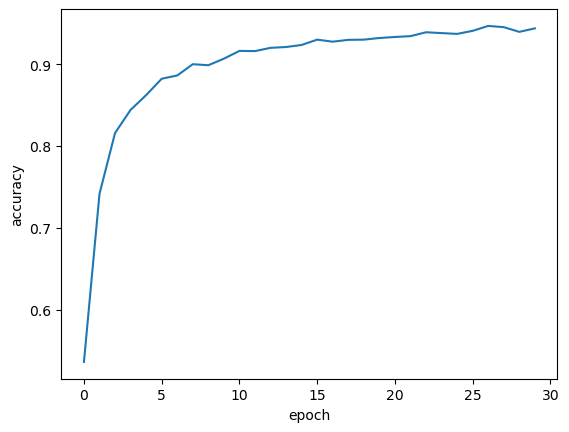

In [26]:
plt.plot(history.history["accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

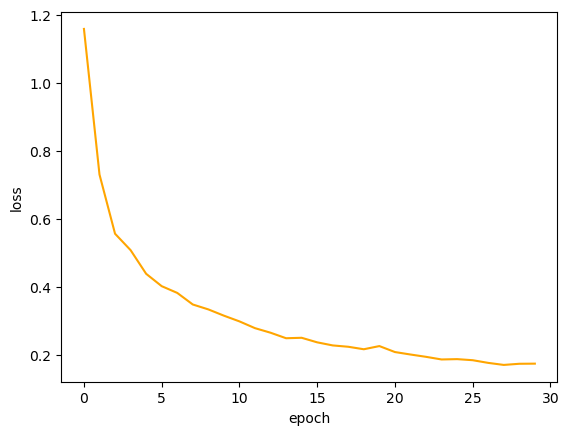

In [27]:
plt.plot(history.history["loss"], color='orange')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [28]:
pred = model.predict(np.array(x_test))

32/32 [==============================] - 1s 14ms/step


In [29]:
score = 0

for i in range(len(pred)):
    if np.argmax(pred[i]) == y_test[i]:
        score+=1

acc = ((score+0.0)/len(pred)*100)
print("Accuracy: {acc}".format(acc = ((score+0.0)/len(pred)*100)))

Accuracy: 92.5


In [30]:
from datetime import datetime
# Get the current date and time
current_time = datetime.now()

# Format the date and time as a string (e.g., "2022-01-01_12-30-45")
formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")

# Combine the formatted time with a base file name
base_file_name = "./model/doodle"

file_name_with_timestamp = f"{base_file_name}.h5"

model.save(file_name_with_timestamp)

In [31]:
from keras.models import load_model

model = load_model("./model/doodle.h5")


In [32]:
def load_numpy_array(file_path):
    """
    Load a NumPy array from a file.

    Parameters:
    - file_path: File path to load the array from.

    Returns:
    - numpy array: Loaded NumPy array.
    """
    loaded_array = np.load(file_path)
    return loaded_array

# # Example Usage:
# file_path = "./user-data.npy"
# loaded_array = load_numpy_array(file_path)
# print("Loaded NumPy array:")
# visualize(denormalize(loaded_array))
# print(model.predict(loaded_array))
# pred = CLASSES[np.argmax(model.predict(loaded_array))]
# print("Predicted:", pred)

In [33]:
from random import randint
def visualize_and_predict():
    "selects a random test case and shows the object, the prediction and the expected result"
    n = randint(0, len(x_test))
    visualize(denormalize(np.reshape(x_test[n], (28, 28))))
    pred = CLASSES[np.argmax(model.predict(np.array([x_test[n]])))]
    actual = CLASSES[y_test[n]]
    print("Actual:", actual)
    print("Predicted:", pred)


### Evaluate model

In [34]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score
)



In [35]:
y_pred = model.predict(np.array(x_test))
y_pred_label = [np.argmax(pred) for pred in y_pred]
# print(np.array(y_test))
# print(y_pred_label)

32/32 [==============================] - 0s 5ms/step


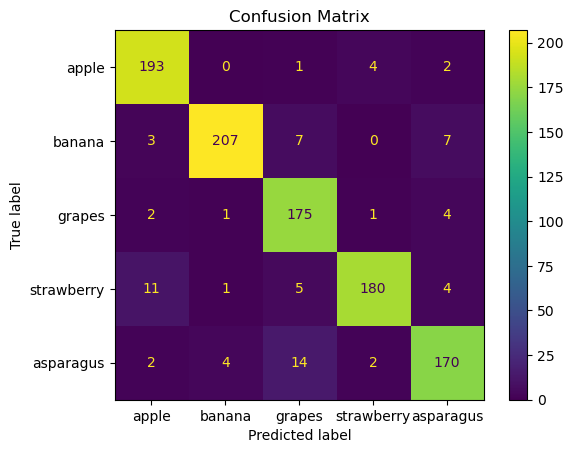

In [38]:
cm = confusion_matrix(y_test, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["apple", "banana", "grapes", "strawberry", "asparagus"])
disp.plot()
disp.ax_.set(title='Confusion Matrix')
plt.show()

In [39]:
print(classification_report(y_test, y_pred_label, target_names=["apple", "banana", "grapes", "strawberry", "asparagus"]))

              precision    recall  f1-score   support

       apple       0.91      0.96      0.94       200
      banana       0.97      0.92      0.95       224
      grapes       0.87      0.96      0.91       183
  strawberry       0.96      0.90      0.93       201
   asparagus       0.91      0.89      0.90       192

    accuracy                           0.93      1000
   macro avg       0.92      0.93      0.92      1000
weighted avg       0.93      0.93      0.93      1000

